In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.optimizers import Adagrad
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
C:\Users\sushr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sushr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sushr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sushr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
import numpy as np
import os 

def save_data(filepath, binary, augment): 
    from keras.utils import np_utils, plot_model
    csv_data = np.genfromtxt(filepath, delimiter=",")
    eeg_data = csv_data[1:]

    labels = []
    cleaned_eeg_data = []

    if binary:  
        for i in range(len(eeg_data)):
            #seizure vs non-seizure only
            labels.append(0 if (eeg_data[i][-1] == 1) else 1)
            cleaned_eeg_data.append((eeg_data[i][:-1])[1:])
    else: 
        for i in range(len(eeg_data)):
            labels.append(eeg_data[i][-1]-1)
            cleaned_eeg_data.append((eeg_data[i][:-1])[1:])

    if augment: 
        labels, cleaned_eeg_data = augment_data(labels, cleaned_eeg_data)

    labels = np.array(labels)
    labels = np_utils.to_categorical(labels)
    np.save("dataset/y_test", labels)
    cleaned_eeg_data = np.array(cleaned_eeg_data)
    cleaned_eeg_data = np.reshape(cleaned_eeg_data, (cleaned_eeg_data.shape[0], cleaned_eeg_data.shape[1], 1, 1))
    np.save("dataset/x_test", cleaned_eeg_data)

    np.savez_compressed("dataset/y_test.npz", labels)
    np.savez_compressed("dataset/x_test.npz", cleaned_eeg_data)
    np.savez_compressed("dataset/x_norm.npz", cleaned_eeg_data)

In [3]:
def save_data_to_3d(filepath, binary, augment): 
    from keras.utils import np_utils, plot_model
    csv_data = np.genfromtxt(filepath, delimiter=",")
    eeg_data = csv_data[1:]

    labels = []
    cleaned_eeg_data = []

    if binary:  
        for i in range(len(eeg_data)):
            #seizure vs non-seizure only
            labels.append(0 if (eeg_data[i][-1] == 1) else 1)
            cleaned_eeg_data.append((eeg_data[i][:-1])[1:])
    else: 
        for i in range(len(eeg_data)):
            labels.append(eeg_data[i][-1]-1)
            cleaned_eeg_data.append((eeg_data[i][:-1])[1:])

    if augment: 
        labels, cleaned_eeg_data = augment_data(labels, cleaned_eeg_data)

    labels = np.array(labels)
    labels = np_utils.to_categorical(labels)
    np.save("dataset/y_test", labels)
    cleaned_eeg_data = np.array(cleaned_eeg_data)
    cleaned_eeg_data = np.reshape(cleaned_eeg_data, (cleaned_eeg_data.shape[0], cleaned_eeg_data.shape[1], 1))
    np.save("dataset/x_test", cleaned_eeg_data)

    #needed for SNNtoolbox
    np.savez_compressed("dataset/y_test.npz", labels)
    np.savez_compressed("dataset/x_test.npz", cleaned_eeg_data)
    np.savez_compressed("dataset/x_norm.npz", cleaned_eeg_data)

In [4]:
def load_data(): 
	exists = os.path.isfile('./dataset/x_test.npy') and os.path.isfile('./dataset/y_test.npy')
	if not exists: 
		raise Exception("Save the data to .npy first! Call save_data(filepath).")

	eeg_data = np.load('./dataset/x_test.npy')
	labels = np.load('./dataset/y_test.npy')

	return eeg_data, labels

In [5]:
save_data_to_3d('C:\\Users\\sushr\\Desktop\\dataset\\data.csv', binary=1, augment=0)

In [6]:
eeg_data = np.load('C:\\Users\\sushr\\Desktop\\dataset\\x_test.npy')
labels = np.load('C:\\Users\\sushr\\Desktop\\dataset\\y_test.npy')

In [7]:
print(eeg_data.shape)
print(labels.shape)

(11500, 178, 1)
(11500, 2)


In [8]:
from keras.layers import LSTM ,Input,GaussianDropout
from keras import models
from keras.models import Model
from keras import layers
from keras.layers import Conv1D, MaxPooling1D
# max_features = 100
# model = Sequential()
# # model.add(layers.Embedding(max_features,32))
# model.add(LSTM(32))
# model.add(Dense(5, activation='sigmoid'))

inputs = Input(shape=(178,1,))
x = Conv1D(32,(3),activation = 'relu')(inputs)
x = Conv1D(32,(3),activation = 'relu')(x)
x = MaxPooling1D(2,2)(x)
x = Conv1D(32,(3),activation = 'relu')(x)
x = MaxPooling1D(2,2)(x)
x = Conv1D(32,(3),activation = 'relu')(x)
x = MaxPooling1D(2,2)(x)
x = Conv1D(32,(3),activation = 'relu')(x)
x = GaussianDropout(0.1)(x)	#generating noise during training for better generalization
x = LSTM(9)(x)
x = Dropout(0.5)(x)
x = Dense(25)(x)
predictions = Dense(units=2, activation="sigmoid")(x)
model1 = Model(inputs, predictions)
# model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
# history=model.fit(Train1,Label_trn,epochs=10,batch_size=128,validation_split=0.2)

In [9]:
import keras
import tensorflow as tf
# adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.SpecificityAtSensitivity(0.7),tf.keras.metrics.SensitivityAtSpecificity(0.7)])

# es = keras.callbacks.EarlyStopping(patience=10)
# tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(os.path.basename(__file__)[:-3]), histogram_freq=1, write_graph=True, write_images=True)

history=model1.fit(eeg_data, labels, epochs=15,batch_size=128, validation_split = 0.2)
model1.save("ourlstmcnn.h5")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 9200 samples, validate on 2300 samples
Epoch 1/15
9200/9200 [==============================] - 6s 662us/step - loss: 0.4440 - accuracy: 0.8047 - specificity_at_sensitivity: 0.8439 - sensitivity_at_specificity: 0.8529 - val_loss: 0.2341 - val_accuracy: 0.9233 - val_specificity_at_sensitivity: 0.8896 - val_sensitivity_at_specificity: 0.8957
Epoch 2/15
9200/9200 [==============================] - 5s 505us/step - loss: 0.2308 - accuracy: 0.8875 - specificity_at_sensitivity: 0.9324 - sensitivity_at_specificity: 0.9318 - val_loss: 0.1220 - val_accuracy: 0.9635 - val_specificity_at_sensitivity: 0.9569 - val_sensitivity_at_specificity: 0.9572
Epoch 3/15
9200/9200 [==============================] - 4s 409us/step - loss: 0.1535 - accuracy: 0.9460 - specificity_at_sensitivity: 0.9683 - sensitivity_at_specificity: 0.9700 - val_loss: 0.0808 - val_accuracy: 0.9772 - val_specificity_at_sensitivity:

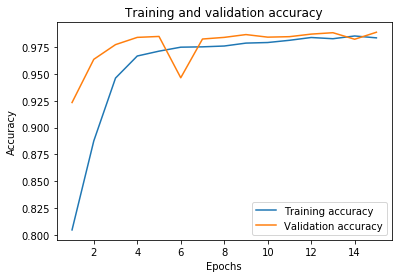

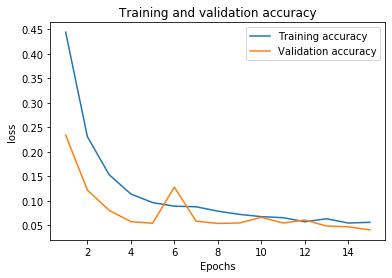

In [10]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,len(acc) + 1)
plt.plot(epochs,acc,label='Training accuracy')
plt.plot(epochs,val_acc,label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc) + 1)
plt.plot(epochs,loss,label='Training accuracy')
plt.plot(epochs,val_loss,label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [11]:
dataset = pd.read_csv('dataset\data.csv')

In [12]:
from numpy.random import RandomState

rng = RandomState()

train = dataset.sample(frac=0.7, random_state=rng)
test = dataset.loc[~dataset.index.isin(train.index)]

# Labels_trn = Labels.sample(frac=0.7, random_state=rng)
# print(train)

# print(dataset)

In [13]:
Labels_trn = train.iloc[:,-1]
Labels_tst = test.iloc[:,-1]

In [14]:
train = train.drop(['y'], axis=1)
train= train.drop(["Unnamed: 0"], axis=1)
test= test.drop(["Unnamed: 0"], axis=1)
test = test.drop(['y'], axis=1)

In [15]:
# res = model.evaluate(Test1, Label_tst)
print(test)
print(Labels_tst)


        X1   X2   X3   X4   X5   X6   X7   X8   X9  X10  ...  X169  X170  \
3     -105 -101  -96  -92  -89  -95 -102 -100  -87  -79  ...   -80   -82   
6      -55   -9   52  111  135  129  103   72   37    0  ...  -137  -125   
16      39   41   41   42   43   43   46   47   49   50  ...    42    43   
19       4   24   51   76   92  102  104  101   90   80  ...     2     3   
20     410  451  491  541  581  641  736  757  692  435  ...   409   415   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
11474  -50  -48  -63  -62  -46  -24   -1   13   27   43  ...    38    44   
11479   62   68   75   75   75   77   81   85   82   81  ...     7    -1   
11482 -121    4  104  185  269  352  405  421  392  369  ...   327   339   
11492  -27  -53  -84 -104 -131 -171 -199 -203 -177 -142  ...  -136  -127   
11498  -40  -25   -9  -12   -2   12    7   19   22   29  ...   114   121   

       X171  X172  X173  X174  X175  X176  X177  X178  
3       -81   -80   -77   -85  

In [16]:
test = np.array(test)
test = np.reshape(test, (test.shape[0], test.shape[1], 1))
print(test)

[[[-105]
  [-101]
  [ -96]
  ...
  [ -72]
  [ -69]
  [ -65]]

 [[ -55]
  [  -9]
  [  52]
  ...
  [  11]
  [  67]
  [ 128]]

 [[  39]
  [  41]
  [  41]
  ...
  [  41]
  [  41]
  [  49]]

 ...

 [[-121]
  [   4]
  [ 104]
  ...
  [ 203]
  [ 145]
  [ 108]]

 [[ -27]
  [ -53]
  [ -84]
  ...
  [ -14]
  [  -8]
  [ -12]]

 [[ -40]
  [ -25]
  [  -9]
  ...
  [  68]
  [  59]
  [  55]]]


In [17]:
Label_trn = Labels_trn.replace({1:0, 2 : 1,3 : 1,4 : 1,5 : 1})
Label_tst = Labels_tst.replace({1:0, 2 : 1,3 : 1,4 : 1,5 : 1})

In [18]:
print(Label_tst)

3        1
6        1
16       1
19       1
20       0
        ..
11474    1
11479    1
11482    0
11492    0
11498    1
Name: y, Length: 3450, dtype: int64


In [19]:
labelstst = np.array(Label_tst)
labelstst = np_utils.to_categorical(Label_tst)

In [20]:
print(labelstst.shape)

(3450, 2)


In [21]:
res = model1.evaluate(test, labelstst)
print(res)

3450/3450 [==============================] - 2s 452us/step
[0.028472134071010825, 0.9905797243118286, 0.9976755976676941, 0.9976755976676941]


In [22]:
res = model1.predict(test)